# CTX Experiment

## Introduction

## Context

The current psychological screening method opaques the analytical vision **because it only evaluates the final score by using a linear relationship of the patient response** at the cost of losing the initial multidimensional mental state information.

mysenii proposes to optimize the linear analysis based on only one final score by exploring the underlying multidimensional mental state information using the TigerGraph graph formatted database approach. The approach will help investigate and target meaningful and dynamic changes in the patient response patterns, latency, decay, and timescale effect, which could be vital for early identification and intervention of mental health conditions.

<img src="img/mysenii_core.jpeg" width="800" />

## Experiment Purpose

The experiment presented here illustrates the mysenii multidimensional patient score proposal and how it can be used to predict and prevent potential mental conditions in patients.

mysenii multidimensional score categorizes traditional psychological test questions by the underlying feeling type (emotion associated with the content question). Using the same score calculation system the traditional screen uses, ponderating each test answer with a value and calculating the sum of all of them, we calculate additional scores, each one corresponding to the total scores of all the test answers associated with the same question category.

In combination with the traditional test score, these new scores provide a more detailed patient screening. This approach helps see the larger picture and visualize noticeable patterns, which is critical in developing a cohesive strategy that will help identify fluctuations in the user response over time and determine a trend in what direction the user's mental state is expected to develop. Understanding this pattern will help in the effective early identification of conditions and personalized intervention plans.

For our experiment, we decided to apply our score proposal to a dataset of actual patients who completed the CES-D depression tests multiple times over different periods. Resultant test scores will be analyzed with time series analysis methods to identify evolution patterns in patient conditions and predict how they could evolve, indicating how our system could use these observations to identify potential risks of suffering from depression and effectively intervene to prevent them.

<INCLUDE SCORE SLIDE FROM PRESENTATION AS IMAGE>

## Experiment Steps

### 1. Experiment Dataset pre-load 

We considered using a dataset from a CES-D actual study to experiment as close as possible to a real case scenario. This test is different from the one implemented in our client application (`CES-D`); however, due to data limitations, we considered taking this dataset over other alternatives such as generating our mock data. 

Reference: https://search.r-project.org/CRAN/refmans/ds4psy/html/posPsy_AHI_CESD.html

In [1]:
import pandas as pd
import numpy as np
import re
import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from faker import Faker
import matplotlib.pyplot as plt
fake = Faker() 

In [2]:
# read raw ahi/ces-d data
data_raw = pd.read_csv('./data/ces-d/ahicesd.csv')
data_raw

id  occasion  elapsed.days  intervention  ahi01  ahi02  ahi03  ahi04  \
0      1         0      0.000000             4      2      3      2      3   
1      1         1     11.772731             4      3      3      4      3   
2      2         0      0.000000             1      3      4      3      4   
3      2         1      8.017523             1      3      4      4      4   
4      2         2     14.304086             1      3      4      4      4   
..   ...       ...           ...           ...    ...    ...    ...    ...   
987  292         0      0.000000             4      2      2      2      2   
988  292         1      9.940718             4      4      3      2      3   
989  293         0      0.000000             2      2      2      2      2   
990  294         0      0.000000             3      3      3      2      3   
991  295         0      0.000000             1      3      3      2      3   

     ahi05  ahi06  ...  cesd13  cesd14  cesd15  cesd16  cesd17  cesd18  \
0        3      2  ...       2       3       1       2       1       1   
1        3      4  ...       1       2       1       3       1       1   
2        2      3  ...       1       1       1       4       1       1   
3        3      3  ...       1       1       1       3       1       1   
4        3      3  ...       3       1       1       1       1       1   
..     ...    ...  ...     ...     ...     ...     ...     ...     ...   
987      2      4  ...       2       2       1       3       2       3   
988      3      4  ...       2       1       1       4       1       1   
989      2      1  ...       1       3       1       2       1       2   
990      3      3  ...       2       2       1       3       1       1   
991      2      3  ...       1       1       1       4       1       2   

     cesd19  cesd20  ahiTotal  cesdTotal  
0         2       2        63         14  
1         1       1        73          6  
2         1       1        73          7  
3         1       1        89         10  
4         1       1        89         13  
..      ...     ...       ...        ...  
987       1       4        50         30  
988       1       3        70          6  
989       1       3        47         18  
990       1       1        70          7  
991       1       1        65          6  

[992 rows x 50 columns]

### 2. Experiment Dataset cleaning & formatting:

   Before proceeding with the experiment, all irrelevant dataset information will be removed, and relevant information will be formatted for easier data handling. The 'occasion' and 'intervention' columns will be removed with all the AHI-test-related columns. The 'elapsed.days' column will also be discarded from our final dataset. This information is relevant for our study; however, the format presented is not optimal, so we will fake it, making some assumptions about the frequency users have to take the test for our predictions to be confident enough. Finally, we will rename the `CES-D` answer columns for easier understanding and change the original scores from 1 to 4 to 0 to 3. Hence, they are more consistent with the `CES-DC` scoring system mentioned in our project documentation.

In [3]:
cesd_answers = data_raw.filter(regex='cesd*').iloc[:, :20].rename(columns=lambda c: re.sub('cesd', 'answer', c))
cesd_answers

answer01  answer02  answer03  answer04  answer05  answer06  answer07  \
0           2         1         1         4         1         2         1   
1           2         1         1         4         1         1         2   
2           1         1         1         1         1         1         1   
3           3         2         1         3         1         1         2   
4           1         1         1         1         1         1         1   
..        ...       ...       ...       ...       ...       ...       ...   
987         4         1         3         2         4         4         4   
988         1         1         1         3         2         1         1   
989         1         1         2         3         1         2         2   
990         2         1         1         3         1         1         1   
991         2         1         1         3         2         1         1   

     answer08  answer09  answer10  answer11  answer12  answer13  answer14  \
0           3         1         1         3         2         2         3   
1           4         1         2         2         4         1         2   
2           1         1         1         2         4         1         1   
3           1         1         1         1         3         1         1   
4           1         1         1         3         4         3         1   
..        ...       ...       ...       ...       ...       ...       ...   
987         2         1         1         1         1         2         2   
988         3         1         1         1         4         2         1   
989         2         1         2         3         2         1         3   
990         3         1         1         2         4         2         2   
991         3         1         2         1         4         1         1   

     answer15  answer16  answer17  answer18  answer19  answer20  
0           1         2         1         1         2         2  
1           1         3         1         1         1         1  
2           1         4         1         1         1         1  
3           1         3         1         1         1         1  
4           1         1         1         1         1         1  
..        ...       ...       ...       ...       ...       ...  
987         1         3         2         3         1         4  
988         1         4         1         1         1         3  
989         1         2         1         2         1         3  
990         1         3         1         1         1         1  
991         1         4         1         2         1         1  

[992 rows x 20 columns]

Looking at the values of the CES-D test answers, we see they range between 1 and 4. For consistency with the literature and simplicity when calculating the scores, we shift those values to the range 0 to 3.

In [4]:
shifted_cesd_answers = cesd_answers - 1

Finally we combine the reformated answers with the corresponding patient IDs.

In [5]:
ids = data_raw.loc[:, 'id']

In [6]:
data = pd.concat([ids, shifted_cesd_answers], axis=1)
data

id  answer01  answer02  answer03  answer04  answer05  answer06  \
0      1         1         0         0         3         0         1   
1      1         1         0         0         3         0         0   
2      2         0         0         0         0         0         0   
3      2         2         1         0         2         0         0   
4      2         0         0         0         0         0         0   
..   ...       ...       ...       ...       ...       ...       ...   
987  292         3         0         2         1         3         3   
988  292         0         0         0         2         1         0   
989  293         0         0         1         2         0         1   
990  294         1         0         0         2         0         0   
991  295         1         0         0         2         1         0   

     answer07  answer08  answer09  ...  answer11  answer12  answer13  \
0           0         2         0  ...         2         1         1   
1           1         3         0  ...         1         3         0   
2           0         0         0  ...         1         3         0   
3           1         0         0  ...         0         2         0   
4           0         0         0  ...         2         3         2   
..        ...       ...       ...  ...       ...       ...       ...   
987         3         1         0  ...         0         0         1   
988         0         2         0  ...         0         3         1   
989         1         1         0  ...         2         1         0   
990         0         2         0  ...         1         3         1   
991         0         2         0  ...         0         3         0   

     answer14  answer15  answer16  answer17  answer18  answer19  answer20  
0           2         0         1         0         0         1         1  
1           1         0         2         0         0         0         0  
2           0         0         3         0         0         0         0  
3           0         0         2         0         0         0         0  
4           0         0         0         0         0         0         0  
..        ...       ...       ...       ...       ...       ...       ...  
987         1         0         2         1         2         0         3  
988         0         0         3         0         0         0         2  
989         2         0         1         0         1         0         2  
990         1         0         2         0         0         0         0  
991         0         0         3         0         1         0         0  

[992 rows x 21 columns]

### 3. Score Calculation
   In the next step, we will calculate our multidimensional score based on the CES-D test question categorization proposed in (1) and the traditional test score. For that, we will sum all the answer scores for the traditional score, and we will add all the answer scores corresponding to each set of questions grouped by their common category for the remaining score dimensions.

   Reference: https://www.rki.de/DE/Content/Gesundheitsmonitoring/Studien/Kiggs/Basiserhebung/Fachartikel/Eur_Child_Adolesc_Psychiatry_2008_17_Suppl_1:116-124.pdf?__blob=publicationFile


In [7]:
IDX = {
    "positive": [3, 7, 11, 15],
    "somatic": [0, 1, 4, 6, 10, 12, 19],
    "depression": [2, 5, 8, 9, 13, 16, 17],
    "interpersonal": [14, 18]
}

def _positive_score(answers):
    # reverting certain scores 
    # reverted_score = abs(old_score - 3) will result in the following mapping of scores
    # 3 -> 0, 1 -> 2, 2 -> 1, 3 -> 0
    idx = IDX['positive']
    reverted_scores = abs(answers.iloc[:, idx] - 3)
    return np.sum(reverted_scores, axis=1)

def scores(df):
    answers = df.filter(regex='answer*')
    scores = {key: np.sum(answers.iloc[:, idx], axis=1) for key, idx in IDX.items()}
    scores['positive'] = _positive_score(answers)
    scores['total_score']=(sum(scores.values()))

    return pd.concat(scores, axis=1)

Given a table where the rows correspond to a patient's ID and the 20 answers to the CES-D(C) test as shown above, the function scores calculates the total score as well as all mentioned sub-scores. Let's calculate scores for the first 5 test results in the data set.

In [8]:
scores(data[:5])

positive  somatic  depression  interpersonal  total_score
0         5        5           3              1           14
1         1        3           2              0            6
2         6        1           0              0            7
3         6        4           0              0           10
4         9        4           0              0           13

### 4. Score Calculation Validation

Before proceeding with the next steps of the experiment, we will verify that our previous score calculations were correct. We will compare the total traditional score of all patient test runs with the total of all the different question category scores summed together. Both score totals should be the same.

In [9]:
np.all(scores(data)['total_score'] == data_raw.loc[:, 'cesdTotal'])

True

### 5. Relevant Sample Selection
   Each row in our dataset represents a screening of a patient. Our dataset can find patients who filled the screening multiple times. Since our goal is to observe patterns in patient screening evolution across time, we should look at the patients who filled the screenings more time. We will filter all screenings, selecting the ones corresponding to the patients with the higher number of screenings. The resulting screening samples will be the ones we will finally use in our experiment.

In [10]:
total_id_count = len(ids.unique())
id_occurences = pd.value_counts(ids)
max_occurence_count = max(id_occurences)
ids_with_enough_occurences = sorted(id_occurences[id_occurences == max_occurence_count].index)

print(f"Total number of IDs: {total_id_count}")
print(f"Maximum occurence of IDs: {max_occurence_count}")
print(f"Number of IDs with enough occurences: {len(ids_with_enough_occurences)}")

Total number of IDs: 295
Maximum occurence of IDs: 6
Number of IDs with enough occurences: 74


We will take all the IDs with maximum number of test samples in the data set and continue with those.

In [78]:
chosen_rows = ids.where([id not in ids_with_enough_occurences for id in ids]).isna()
data_filtered = data[chosen_rows].reset_index(drop=True)
data_filtered = pd.concat([data_filtered, scores(data_filtered)], axis=1)
data_filtered

id  answer01  answer02  answer03  answer04  answer05  answer06  \
0      2         0         0         0         0         0         0   
1      2         2         1         0         2         0         0   
2      2         0         0         0         0         0         0   
3      2         0         0         0         0         0         0   
4      2         1         2         1         0         0         1   
..   ...       ...       ...       ...       ...       ...       ...   
439  283         1         0         0         3         1         0   
440  283         0         0         0         2         2         0   
441  283         0         0         0         3         0         0   
442  283         2         1         1         2         1         1   
443  283         1         0         0         2         1         0   

     answer07  answer08  answer09  ...  answer16  answer17  answer18  \
0           0         0         0  ...         3         0         0   
1           1         0         0  ...         2         0         0   
2           0         0         0  ...         0         0         0   
3           0         3         0  ...         2         0         0   
4           1         3         0  ...         2         0         1   
..        ...       ...       ...  ...       ...       ...       ...   
439         1         2         0  ...         2         0         0   
440         1         2         0  ...         2         0         0   
441         1         3         0  ...         3         0         0   
442         1         2         0  ...         2         2         0   
443         0         3         0  ...         3         0         1   

     answer19  answer20  positive  somatic  depression  interpersonal  \
0           0         0         6        1           0              0   
1           0         0         6        4           0              0   
2           0         0         9        4           0              0   
3           0         0         7        1           0              0   
4           0         0         5        7           3              0   
..        ...       ...       ...      ...         ...            ...   
439         1         1         3        8           0              1   
440         0         1         4        8           0              0   
441         1         1         1        6           0              1   
442         0         1         4       10           4              0   
443         0         0         2        4           1              0   

     total_score  
0              7  
1             10  
2             13  
3              8  
4             15  
..           ...  
439           12  
440           12  
441            8  
442           18  
443            7  

[444 rows x 26 columns]

### 6. Patient Screening Time Distribution
   The date on which each patient filled the screenings are irregularly distributed across the time. To have a consistent time distribution of the other screenings taken by patients, we will assume that test results were collected every month. With this data modification, we will be able to do more meaningful observations and comparisons of screenings from the same patient and between patients. The next step adds a new `timestamp` column to each screening, implementing a one-month progression between subsequent screenings.

In [79]:
def date_series():
    initial_date = fake.date_time_between(start_date='-5y', end_date='now')
    date_range = pd.date_range(initial_date, periods=max_occurence_count, freq="M")
    
    return date_range.to_pydatetime()

dates = [date_series() for i in range(len(ids_with_enough_occurences))]
data_filtered.insert(1, 'timestamp', np.concatenate(dates).astype(np.str))
data_filtered.insert(1, 'screening_id', "screening_" + data_filtered["timestamp"])
data_filtered.insert(1, 'results_id', "results_" + data_filtered["timestamp"])
data_filtered.insert(1, 'user_id', "user_" + data_filtered["id"].astype(str))
data_filtered

id   user_id                   results_id  \
0      2    user_2  results_2018-06-30 20:08:14   
1      2    user_2  results_2018-07-31 20:08:14   
2      2    user_2  results_2018-08-31 20:08:14   
3      2    user_2  results_2018-09-30 20:08:14   
4      2    user_2  results_2018-10-31 20:08:14   
..   ...       ...                          ...   
439  283  user_283  results_2017-06-30 19:37:23   
440  283  user_283  results_2017-07-31 19:37:23   
441  283  user_283  results_2017-08-31 19:37:23   
442  283  user_283  results_2017-09-30 19:37:23   
443  283  user_283  results_2017-10-31 19:37:23   

                      screening_id            timestamp  answer01  answer02  \
0    screening_2018-06-30 20:08:14  2018-06-30 20:08:14         0         0   
1    screening_2018-07-31 20:08:14  2018-07-31 20:08:14         2         1   
2    screening_2018-08-31 20:08:14  2018-08-31 20:08:14         0         0   
3    screening_2018-09-30 20:08:14  2018-09-30 20:08:14         0         0   
4    screening_2018-10-31 20:08:14  2018-10-31 20:08:14         1         2   
..                             ...                  ...       ...       ...   
439  screening_2017-06-30 19:37:23  2017-06-30 19:37:23         1         0   
440  screening_2017-07-31 19:37:23  2017-07-31 19:37:23         0         0   
441  screening_2017-08-31 19:37:23  2017-08-31 19:37:23         0         0   
442  screening_2017-09-30 19:37:23  2017-09-30 19:37:23         2         1   
443  screening_2017-10-31 19:37:23  2017-10-31 19:37:23         1         0   

     answer03  answer04  answer05  ...  answer16  answer17  answer18  \
0           0         0         0  ...         3         0         0   
1           0         2         0  ...         2         0         0   
2           0         0         0  ...         0         0         0   
3           0         0         0  ...         2         0         0   
4           1         0         0  ...         2         0         1   
..        ...       ...       ...  ...       ...       ...       ...   
439         0         3         1  ...         2         0         0   
440         0         2         2  ...         2         0         0   
441         0         3         0  ...         3         0         0   
442         1         2         1  ...         2         2         0   
443         0         2         1  ...         3         0         1   

     answer19  answer20  positive  somatic  depression  interpersonal  \
0           0         0         6        1           0              0   
1           0         0         6        4           0              0   
2           0         0         9        4           0              0   
3           0         0         7        1           0              0   
4           0         0         5        7           3              0   
..        ...       ...       ...      ...         ...            ...   
439         1         1         3        8           0              1   
440         0         1         4        8           0              0   
441         1         1         1        6           0              1   
442         0         1         4       10           4              0   
443         0         0         2        4           1              0   

     total_score  
0              7  
1             10  
2             13  
3              8  
4             15  
..           ...  
439           12  
440           12  
441            8  
442           18  
443            7  

[444 rows x 30 columns]

### 7. Inject data into TigerGraph instance

As we have the simulation data in shape now, we can inject the data in our prepared TigerGraph db instance. To do so, we first connect to the instance and then define a function to upload the data properly to the corresponding objects in data graph.

Our database schema is defined in a separate notebook you can find here [TigerGraphMysenii](./TigerGraphMysenii.ipynb)

In [48]:
import pyTigerGraph as tg

GRAPH_NAME = 'MyseniiDepressionScreening'
hostName = "https://mysenii.i.tgcloud.io"
userName = "tigergraph"
password = "GMjgfTXRn3Db"

conn = tg.TigerGraphConnection(host=hostName, username=userName, password=password)
print("connected")
conn.graphname = GRAPH_NAME
secret = conn.createSecret()
token = conn.getToken(secret, setToken=True)
conn.apiToken = token[0]

connected


In [80]:
def upload_data(conn, data):
    conn.upsertVertexDataFrame(data, "User", "user_id", 
                               attributes = { "id": "user_id"})
    conn.upsertVertexDataFrame(data, "Screening", "screening_id", 
                               attributes = { "id": "screening_id", "timestamp": "timestamp"})
    conn.upsertVertexDataFrame(data, "Results", "results_id", 
                               attributes = { "id": "results_id", "score": "total_score"})
    conn.upsertEdgeDataFrame(
        data, "User", "has_screening", "Screening", 
        from_id="user_id", to_id="screening_id", attributes={}
    )
    conn.upsertEdgeDataFrame(
        data, "Screening", "has_results", "Results", 
        from_id="screening_id", to_id="results_id", attributes={}
    )
    
    
    for index, key in enumerate(data.filter(regex='answer*')):
        answer_df = pd.DataFrame(
            data={
                "source_id": f"screening_answer_{index+1}_" + data["timestamp"].values,
                "target_id": f"question{index+1}answer" + (data[key] + 1).astype(str).values,
                "screening_id": data["screening_id"].values,
                "timestamp": data["timestamp"].values
            },
            index=f"screening_answer_{index+1}_" + data["timestamp"].values
         )
        
        conn.upsertVertexDataFrame(
            answer_df, "ScreeningAnswer", "source_id", 
            attributes = { "id": "source_id", "timestamp": "timestamp"}
        )
        conn.upsertEdgeDataFrame(
            answer_df, "ScreeningAnswer", "selects_answer", "Answer", 
            from_id="source_id", to_id="target_id", attributes = {}
        )
        conn.upsertEdgeDataFrame(
            answer_df, "Screening", "has_screening_answer", "ScreeningAnswer", 
            from_id="screening_id", to_id="source_id", attributes = {}
        )

In [82]:
upload_data(conn, data_filtered)

We successfully injected our simulation data into TigerGraph! Using TigerGraph Studio we can have take a look now at the data. 

<img src="img/tg_user_screening.png" />

### 8. Sample Selection for Simulation & Data Exploration
   In the next steps, we will select specific user screenings to perform an analysis of their time-series data.

In [51]:
user_data = data_filtered[data_filtered.loc[:, 'id'] == data_filtered['id'].unique()[0]]
user_data

id                   results_id                   screening_id user_id  \
0   2  results_2019-08-31 18:57:46  screening_2019-08-31 18:57:46  user_2   
1   2  results_2019-09-30 18:57:46  screening_2019-09-30 18:57:46  user_2   
2   2  results_2019-10-31 18:57:46  screening_2019-10-31 18:57:46  user_2   
3   2  results_2019-11-30 18:57:46  screening_2019-11-30 18:57:46  user_2   
4   2  results_2019-12-31 18:57:46  screening_2019-12-31 18:57:46  user_2   
5   2  results_2020-01-31 18:57:46  screening_2020-01-31 18:57:46  user_2   

             timestamp  answer01  answer02  answer03  answer04  answer05  ...  \
0  2019-08-31 18:57:46         0         0         0         0         0  ...   
1  2019-09-30 18:57:46         2         1         0         2         0  ...   
2  2019-10-31 18:57:46         0         0         0         0         0  ...   
3  2019-11-30 18:57:46         0         0         0         0         0  ...   
4  2019-12-31 18:57:46         1         2         1         0         0  ...   
5  2020-01-31 18:57:46         1         0         1         3         1  ...   

   answer16  answer17  answer18  answer19  answer20  positive  somatic  \
0         3         0         0         0         0         6        1   
1         2         0         0         0         0         6        4   
2         0         0         0         0         0         9        4   
3         2         0         0         0         0         7        1   
4         2         0         1         0         0         5        7   
5         3         1         1         0         0         2        5   

   depression  interpersonal  total_score  
0           0              0            7  
1           0              0           10  
2           0              0           13  
3           0              0            8  
4           3              0           15  
5           5              0           12  

[6 rows x 30 columns]

Also we will calculate the scores as we want to work with those in the following.

In [16]:
scores(user_data)

positive  somatic  depression  interpersonal  total_score
0         6        1           0              0            7
1         6        4           0              0           10
2         9        4           0              0           13
3         7        1           0              0            8
4         5        7           3              0           15
5         2        5           5              0           12

### 9. Screening Scores Interpolation

Observing the resultant patient screening series, we deduce the amount of screenings is still not significant for proper time analysis. To increase the number of screenings we will use interpolation techniques to artificially expand the screenings, arranged in a monthly-based frequency, in a weekly-based frequency. This is a mathematical valid approach for creating new tests scores, but that drifts away from the real case scenario approach we initially pursued. Due to the scope of the hackathon and our goal of proving the feasibility of our solution, we consider this approach is still valid for our purposes and thus we will proceed with it.

In order to sample those data points, we kind of "blow up" our table by inserting a certain number of blank rows and call an interpolation method on it. We decide for a polynomial interpolation of order 3 to smooth out the score curves, the blank rows will be filled with the calculated values.

In [17]:
def insert_empty_rows(df, row_count=3):
    df_new = pd.DataFrame()
    for i, row in df.iterrows():
        df_new = df_new.append(row)
        df_new = df_new.append([pd.Series()] * row_count, ignore_index=True)
    return df_new.iloc[:-row_count]

user_scores = insert_empty_rows(scores(user_data))
interpolated_scores = user_scores.interpolate(method='polynomial', order=3, axis=0)
interpolated_scores


<ipython-input-17-0b75d1af3a67>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_new = df_new.append([pd.Series()] * row_count, ignore_index=True)


depression  interpersonal  positive   somatic  total_score
0     0.000000            0.0  6.000000  1.000000     7.000000
1    -0.069271            0.0  5.069792  1.750521     6.751042
2    -0.079167            0.0  4.883333  2.554167     7.358333
3    -0.049479            0.0  5.255208  3.330729     8.536458
4     0.000000            0.0  6.000000  4.000000    10.000000
5     0.049479            0.0  6.932292  4.481771    11.463542
6     0.079167            0.0  7.866667  4.695833    12.641667
7     0.069271            0.0  8.617708  4.561979    13.248958
8     0.000000            0.0  9.000000  4.000000    13.000000
9    -0.128646            0.0  8.888542  3.009896    11.769792
10   -0.237500            0.0  8.400000  1.912500    10.075000
11   -0.227604            0.0  7.711458  1.108854     8.592708
12    0.000000            0.0  7.000000  1.000000     8.000000
13    0.511979            0.0  6.404167  1.853646     8.769792
14    1.245833            0.0  5.908333  3.404167    10.558333
15    2.106771            0.0  5.458333  5.252604    12.817708
16    3.000000            0.0  5.000000  7.000000    15.000000
17    3.830729            0.0  4.479167  8.247396    16.557292
18    4.504167            0.0  3.841667  8.595833    16.941667
19    4.925521            0.0  3.033333  7.646354    15.605208
20    5.000000            0.0  2.000000  5.000000    12.000000

Let's compare the original score curves (left) with the interpolated ones (right).

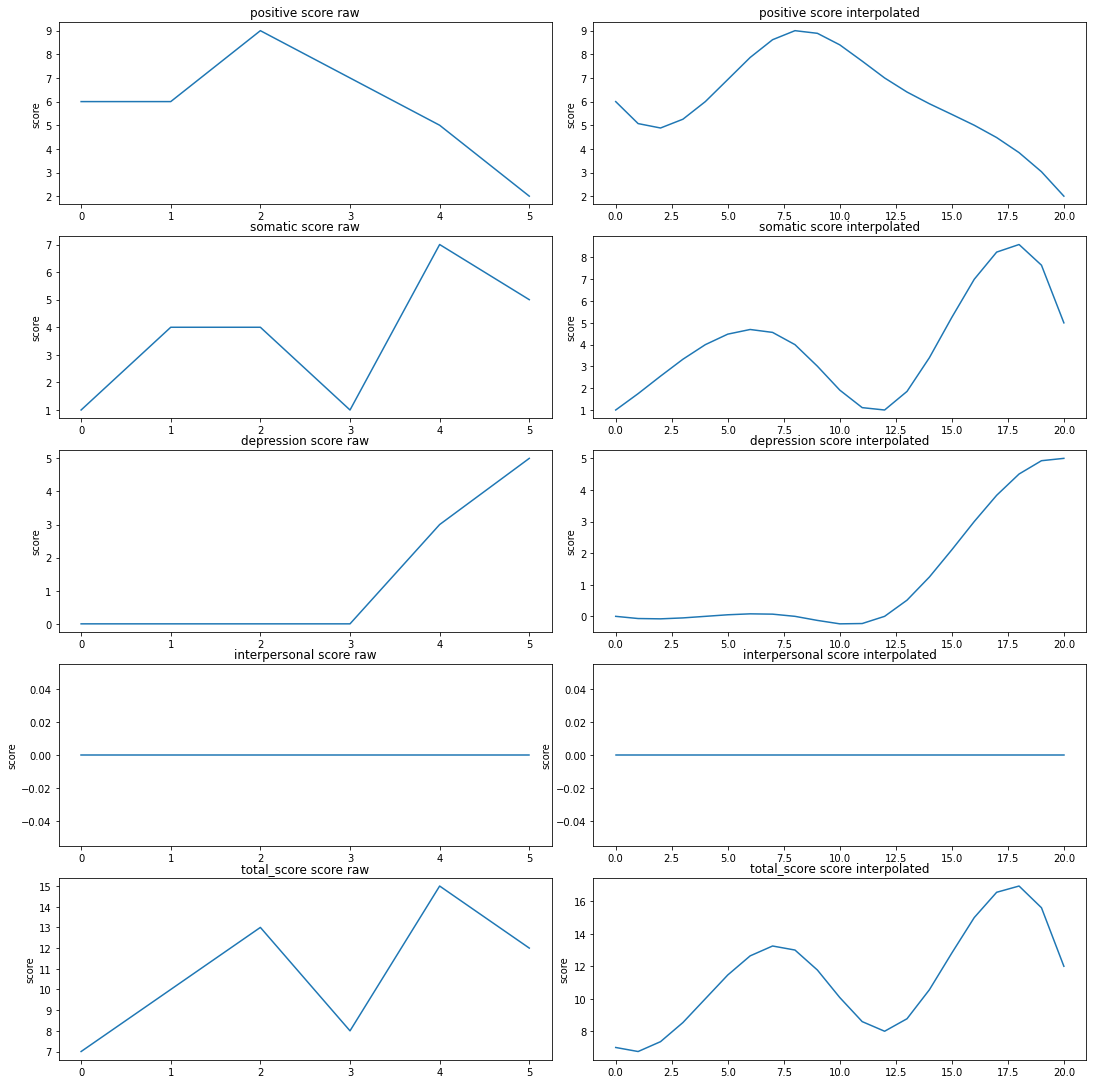

In [18]:
original_scores = scores(user_data)
fig, axes = plt.subplots(5, 2, figsize=(15, 15))
fig.tight_layout()
for index, key in enumerate(original_scores):
    ax1, ax2 = axes[index]
    ax1.plot(original_scores[key])
    ax2.plot(interpolated_scores[key])
    ax1.set_title(f"{key} score raw"); ax2.set_title(f"{key} score interpolated")
    ax1.set_ylabel("score"); ax2.set_ylabel("score"); 

### 10. Moving Averages

As we want to provide some average scores in the UI, we need to calculate those at some point. As it does not make sense to take into account data from too far in the past, we will use a moving average with a time window of 2 months or 8 weeks respectively.

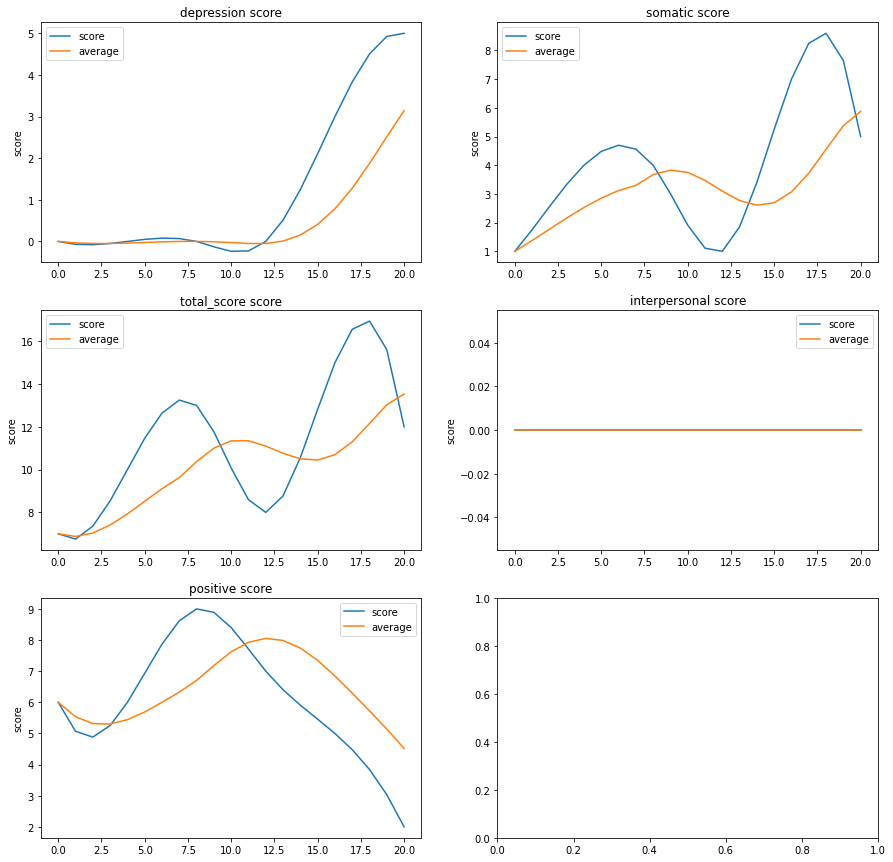

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
for i, key in enumerate(interpolated_scores):
    ax = axes[i % 3, i % 2]
    average = interpolated_scores[key].rolling(window=8, min_periods=0).mean()
    ax.set_title(f"{key} score")
    ax.plot(interpolated_scores[key], label='score')
    ax.plot(average, label='average')
    ax.set_ylabel("score"); ax2.set_ylabel("score value"); 
    ax.legend()

These calculated averages can be used now in the spider graph diagram to provide a comprehensive overview about the user's performance in comparison to the latest test results.

<img src="img/spider_graph.png" width="350" height="350" />

### 11. Forecasting the next test score

Based on the user's test history, we would like give a prediction on the user's next test run to see whether the user continues to follw a certain trend he has been showing before or something in the answering behaviour changed.

The analysis of time series health data such as clinical scores has been the subject of past as well as ongoing
research. A case study similar to our simulation has been performed by Holmes, E A et al. “Applications of time-series analysis to mood fluctuations in bipolar disorder to promote treatment innovation: a case series.” in the context of research on bipolar disorders. There an <b>AR</b> prediction model is applied to a series of mood scores collected on a daily and weekly basis with the goal to identify mood swings.

Reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5068881/

Instead of using an <b>AR</b> model like in the referenced work, we come up with the more general case of an <b>ARIMA</b> prediction model. In order to define the model, we have to determine the necessary ARIMA parameters 
- d: the number of times that the raw observations are differenced; also known as the degree of differencing.
- p: the number of lag observations in the model; also known as the lag order.
- q: the size of the moving average window; also known as the order of the moving average.


An introduction to ARIMA models and descriptions of the process of defining a suitable ARIMA model can be found here 

References: <br>
  https://vitalflux.com/autoregressive-ar-models-with-python-examples/<br>
  https://www.projectpro.io/article/how-to-build-arima-model-in-python/544

For parameter q, we will have a look at the series' autocorrelation plot first.

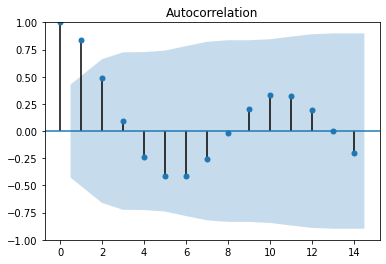

In [20]:
plot_acf(interpolated_scores['total_score']);

Knowing that we applied some polynomial interpolation of order 3 to the data, it is valid to assume the series turns out to be stationary after differencing 3 times. To test when to stop differencing, we perform a hypothesis test (Augmented Dickey-Fuller) and compare the result to a threshold of 0.05.

Order: 1, ADF test result: 0.9986885935094512
Order: 2, ADF test result: 0.847883282447093
Order: 3, ADF test result: 0.0


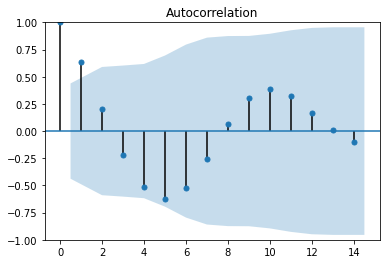

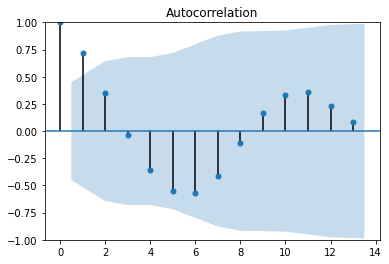

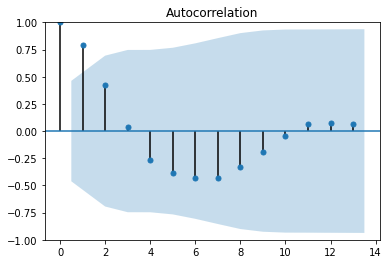

In [21]:
diffed = interpolated_scores['total_score']
for i in range(3):
    diffed = diffed.diff()
    print(f"Order: {i+1}, ADF test result: {adfuller(diffed.dropna(), autolag='AIC')[1]}")
    plot_acf(diffed.dropna())

As assumed, differencing 3 times makes the series stationary, even though it is in a state called 'over-differenced' then. Even though the adf test value after differencing 2 times is far away from the threshold of 0.05, we will stick to d = 2 first and try to balance by chosing p and q properly.

In [22]:
d = 2

Plotting the partial autocorrelation after differencing 2 times, we see that the first lag exceeds the limit (blue area) and the second one does too but slightly. As we haven taken a compromis by setting parameter d, we will be strict here and chose p = 2.

/home/docyet/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


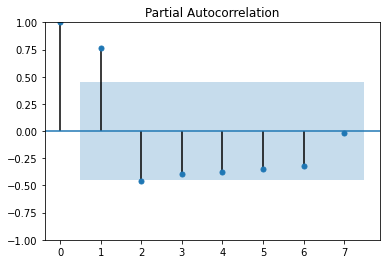

In [23]:
plot_pacf(interpolated_scores['total_score'].diff().diff().dropna(), lags=7);

In [24]:
p = 2

For the choice of q we take a look at the correlation plots above. Only one leg exceeds the threshold area in all plots, so q = 1 is the choice here.

In [25]:
q = 1

Having now choices for all necessary parameters, we can come up with a forecasting model. To compare the forecast with some realistic value, we omit the last values of the series in the model fitting process.

In [26]:
arima_model = ARIMA(interpolated_scores['total_score'].values[:-5], order=(d, p, q))
model = arima_model.fit()
model.summary()

/home/docyet/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/docyet/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   16
Model:                 ARIMA(2, 2, 1)   Log Likelihood                   3.497
Date:                Wed, 20 Apr 2022   AIC                              1.005
Time:                        17:39:27   BIC                              3.561
Sample:                             0   HQIC                             0.768
                                 - 16                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6419      0.086     19.004      0.000       1.473       1.811
ar.L2         -0.9798      0.048    -20.545      0.000      -1.073      -0.886
ma.L1         -0.9863      6.514     -0.151      0.880     -13.754      11.781
sigma2         0.0204      0.128      0.160      0.873      -0.230       0.271
===================================================================================
Ljung-Box (L1) (Q):                   1.08   Jarque-Bera (JB):                 1.35
Prob(Q):                              0.30   Prob(JB):                         0.51
Heteroskedasticity (H):               1.06   Skew:                            -0.74
Prob(H) (two-sided):                  0.95   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Let's come up with some prediction using the model.

In [27]:
predicted = np.concatenate([model.predict(), model.forecast(5)])

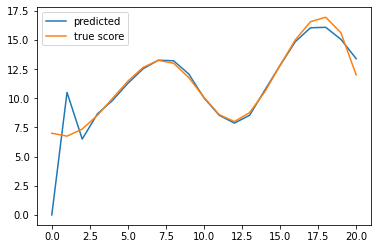

In [28]:
plt.plot(predicted, label="predicted");
plt.plot(interpolated_scores['total_score'], label="true score");
plt.legend();
plt.show()

In [29]:
err = abs(interpolated_scores['total_score'].values[-1] - predicted[-1])
print(f"Prediction error: {err}")

Prediction error: 1.3909288238319455


We see that the user behaved in the way his previous test results indicated already and improved his total score, achieving a score even slightly better than the one forecasted. We could now congratulate the user for sticking to the (expected) positive trend and improvement.

 The application of a similar modeled ARIMA approach to the other scores can be executed analogously. Doing so, we can draw similar conclusions for each of the sub-scores, gathering even more information on the user's mental health as well as possibilities to intervene by providing more targeted help with respect to the user's changes in mood.

## Possible future work



The assumption of having regular shaped time intervals in between subsequent test results has been simplifying the time series analysis in this simulation a lot. Real world health data is commonly irregularly sampled and the search for applicable methods to analyze this kind of data is subject of ongoing research. 

The proposals for those methods range from using more sophisticated statistical methods to using special neural network architectures such as GANs to sample missing data points and finally turn the irregularly sampled series into a regular one. 

Reference: https://arxiv.org/abs/2010.12493

The implementation of those methods for this Hackathon challenge is due to limitations in both time and availability of data beyond the scope of this submission, even though remains an interesting topic to deal with in future.